# Summary of contents
In this notebook, I present the solution to Assignment 3. The notebook is divided in the following sections:

### **Dataset selection** 
In this assignment, we have decided to work on a fraud detection problem using a credit card dataset available on [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). The goal is to find the signal (i.e. anomalous) transactions on a highly imbalanced dataset, with lots of backgrouns (i.e. non-anomalous) transactions.

### **1) Exploratory Data Analysis** 

**a)** Load, clean and visualize the input data, exploring the feature distribution for signal and background events.<br>
**b)** Examine the correlations between input features.<br>
**c)** Apply a T-SNE embedding in 2D to explore the separability of signal and background events.<br>
**d)** Preprocess data

### **2) Dealing with imbalanced datasets: undersampling, oversampling and cross-validation** 

**a)** We will describe undersampling and oversampling techniques to balance our dataset when taining our models.<br> 
**b)** We talk about the importance of cross-validation as a model evalaution strategy.<br> 
**c)** We explain how to merge these techniques when training our models.

### **3) Fully supervised classification**

**a)** We implement a Random Forest, Logistic Regression and a Neural Network to classify signal vs. background events. <br>
**b)** We define precision and recall as the metrics to evaluate the model performance.

### **4) Unsupervised model**

**a)** We implement a Variational Autoencoder to learn the background probability distribution. <br>
**b)** We use the reconstruction loss to select a sample of anomalous signal-like events.

### **Summary of results**
We find that training a Neural Network using nested cross-validation and oversampling yields excellent performance, allowing to classify most signal and background events correctly. Random Forest can be used out of the box to achieve a high performance.

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Layer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import auc, roc_auc_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, \
    precision_score, recall_score, f1_score

from src.utils import shuffle_2d, plot_prc
from src.balancing import score_model_unbalanced, score_model_undersampling, score_model_oversampling

%load_ext autoreload
%aimport
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



# 1) Exploring the dataset

## 1.1) Clean, normalize and visualize input data

In [2]:
# Load data from file
data = pd.read_csv("data/dataset2.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Get some basic information about the dataset
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
# Check for null values
data.isnull().sum().sum()

0

In [5]:
# Check signal and background events
print('Background: %.2f %% of the dataset' % (data['Class'].value_counts()[0]/len(data)*100))
print('Signal: %.2f %% of the dataset' % (data['Class'].value_counts()[1]/len(data)*100))

Background: 99.83 % of the dataset
Signal: 0.17 % of the dataset


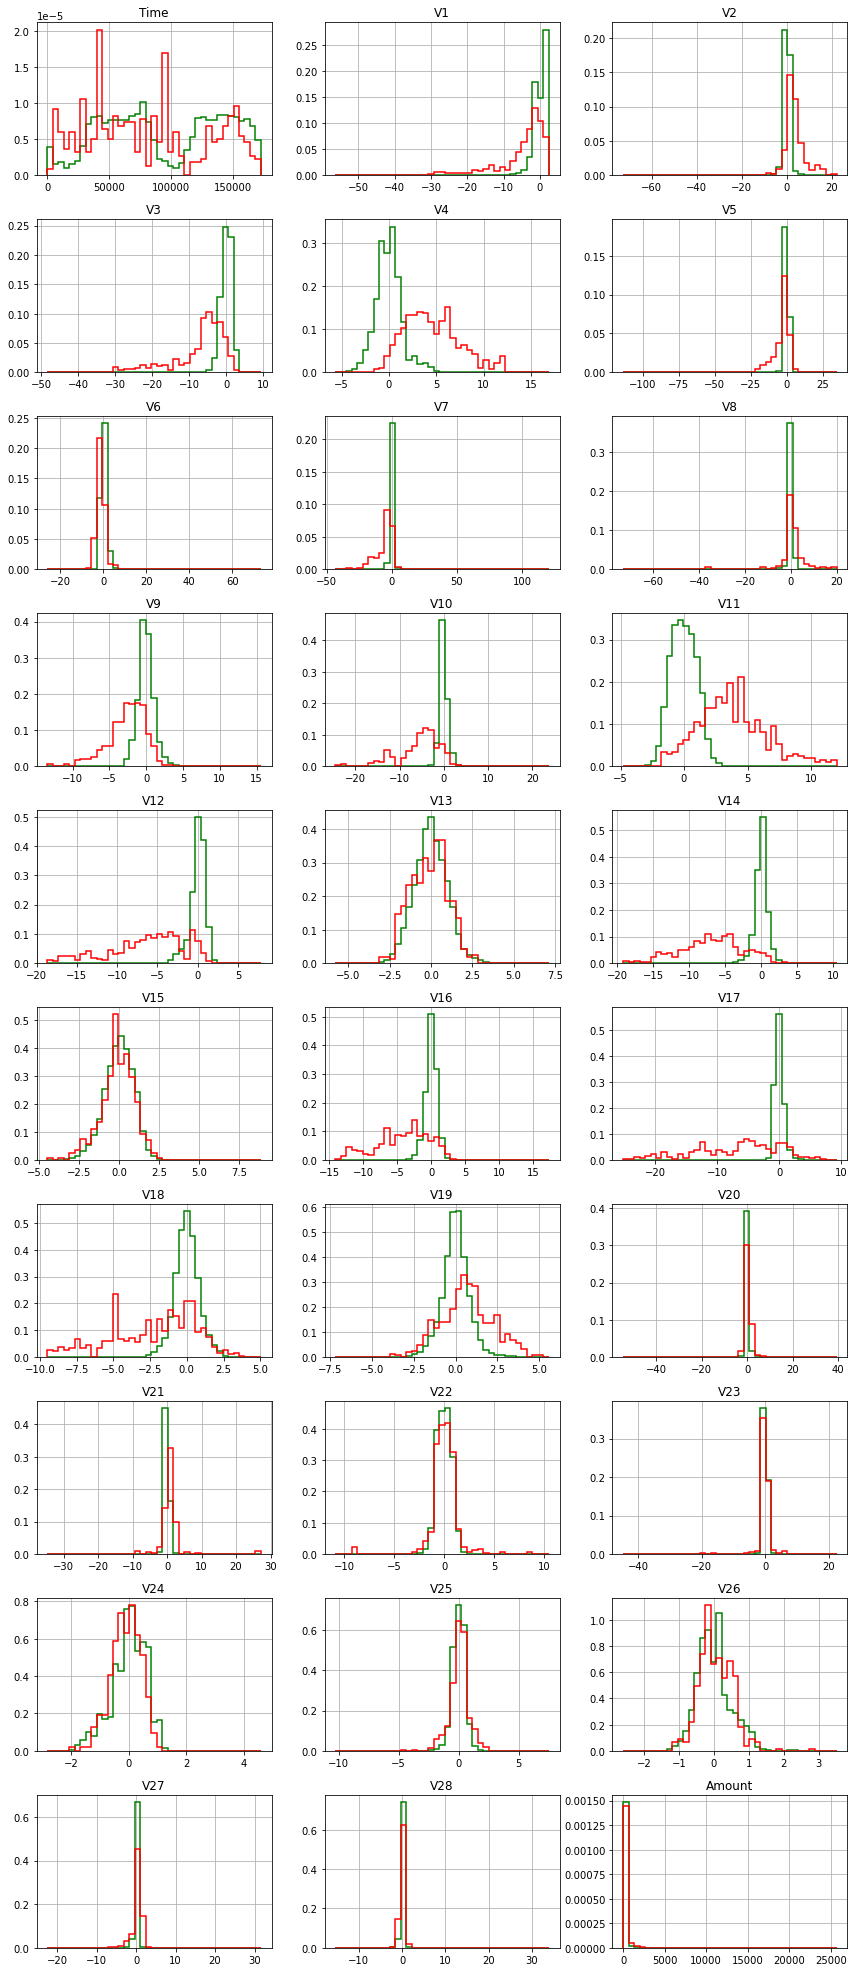

In [6]:
# Plot the distribution of input features for signal and background
fig, ax = plt.subplots(figsize=(12, 30))    # (width, height)

for n, col in enumerate(data.columns[:-1]):
    
    # Add subplot
    plt.subplot(11, 3, n+1)
    
    # Define bins
    bins = np.linspace(data[col].min(), data[col].max(), 40)
    
    # Plot entries
    data[col].loc[data['Class'] == 0].hist(bins=bins, density=True, histtype='step', color='g', linewidth=1.5, 
                                           alpha=1, ax=plt.gca())
    data[col].loc[data['Class'] == 1].hist(bins=bins, density=True, histtype='step', color='r', linewidth=1.5, 
                                           alpha=1, ax=plt.gca())
    
    # Options
    plt.title(col)
    
# Space plots nicely
plt.tight_layout()

# Save and close
# plt.savefig("/home/pablo/Documentos/challenge/plots/all_data.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

## 1.2) Explore correlations with a balanced dataset

In [7]:
# Take all signal and a random subsample of background
sg = data.loc[data['Class'] == 1]
bg = data.loc[data['Class'] == 0].sample(frac=1)[:len(sg)]

# Join both dataframes
data_reduced = pd.concat([sg, bg], axis=0).sample(frac=1)

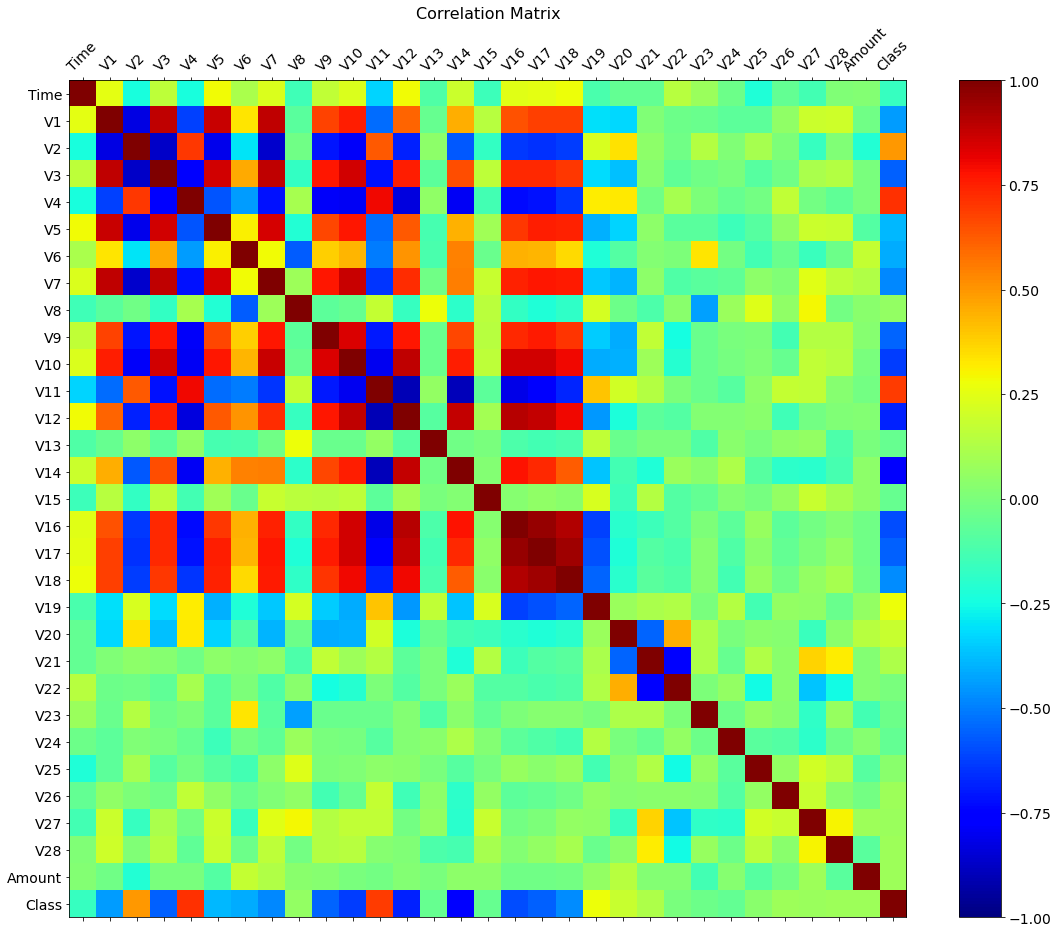

In [8]:
# Plot the correlation matrix
fig = plt.figure(figsize=(19, 15))

# Plot matrix
plt.matshow(data_reduced.corr(), cmap=plt.cm.jet, vmin=-1, vmax=1, fignum=fig.number)

# Options
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=45)
plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

# Save and close
# plt.savefig("/home/pablo/Documentos/challenge/plots/correlation_matrix_full.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

### Conclusion
As we did see in the plots, not all features are highly-correlated with the class labels. Two things that stand out here are:
* The first features seem to show higher correlations with the labels, which is consistent with the nature of the dataset since the features are the result of a PCA.
* Some features show high correlations among themselves, which suggests that there could be some room for feature engineering.

For the baseline models, we will use all features. A detailed feature engineering process may improve results of the baseline models.

## 1.3) T-SNE with truth labels

In [9]:
# Define numpy arrays with all input features (X) and labels (Y)
X_reduced = data_reduced.drop(['Class'], axis=1).values
Y_reduced = data_reduced["Class"].values

In [10]:
# Use T-SNE to visualize data in 2D
tsne = TSNE(n_components=2, perplexity=80, learning_rate='auto', init='random', n_iter=300, random_state=123)

# Fit data to embedded space
X_tsne = tsne.fit_transform(X_reduced)

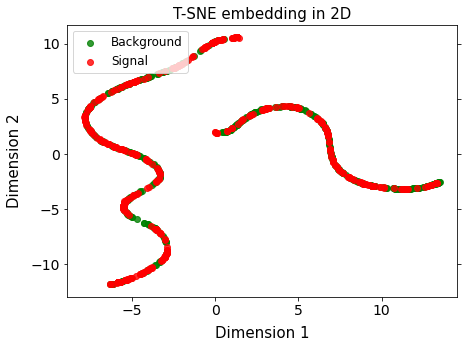

In [11]:
# Define figure
fig = plt.figure(figsize=(7,5))

# Plot data
plt.scatter(X_tsne[np.where(Y_reduced == 0), 0], X_tsne[np.where(Y_reduced == 0), 1], marker='o', color='g', 
            alpha=0.8, label='Background')
plt.scatter(X_tsne[np.where(Y_reduced == 1), 0], X_tsne[np.where(Y_reduced == 1), 1], marker='o', color='r', 
            alpha=0.8, label='Signal')

# Options
plt.title(r'T-SNE embedding in 2D', fontsize=15)
plt.xlabel(r'Dimension 1', fontsize=15, labelpad=8)
plt.ylabel(r'Dimension 2', fontsize=15, labelpad=8)
plt.legend(loc='upper left', fontsize=12) 
plt.tick_params(which='both', direction='out', bottom=True, left=True, right=True, labelsize=14)

# Save and close
# plt.savefig("/home/pablo/Documentos/challenge/plots/t-sne.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

### Conclusion
The T-SNE embedding shows that we may have some trouble separing the classes. This is just a quick test to see how difficult the problem may be. Note that the T-SNE embedding is only useful when working with balanced classes. If we apply it on an imbalanced dataset, it won't be able to distinguish the two classes (signal vs. background).

## 1.4) Data preprocessing
We will preprocess all features by applying either the standard scaler (standardization) or the robust scaler (which is more robust against outliers). Unless otherwise states in the notebook, all features will be standardized, as shown below.

In [12]:
# Scale the variables that are not scaled
std_scaler = StandardScaler()   # Standardize
rob_scaler = RobustScaler()     # Robust to outliers

# Scale all variables
for col in data.columns[:-1]:
    data[col] = std_scaler.fit_transform(data[col].values.reshape(-1,1))

In [13]:
# Get some basic information about the dataset
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,-3.065637e-16,-1.506872e-17,-9.580116e-18,-8.622104e-17,-5.189230e-18,3.832046e-17,9.979288e-18,1.237432e-17,-3.193372e-18,7.234983e-19,...,-3.642440e-18,3.193372e-18,8.781773e-18,9.580116e-18,-5.029561e-17,5.887780e-18,2.444925e-18,-7.908585e-18,2.913952e-17,0.001727
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.041527
min,-1.996583e+00,-2.879855e+01,-4.403529e+01,-3.187173e+01,-4.013919e+00,-8.240810e+01,-1.963606e+01,-3.520940e+01,-6.130252e+01,-1.222802e+01,...,-4.741907e+01,-1.506565e+01,-7.175446e+01,-4.683638e+00,-1.975033e+01,-5.401098e+00,-5.590660e+01,-4.674612e+01,-3.532294e-01,0.000000
25%,-8.552120e-01,-4.698918e-01,-3.624707e-01,-5.872142e-01,-5.993788e-01,-5.010686e-01,-5.766822e-01,-4.478860e-01,-1.746805e-01,-5.853631e-01,...,-3.109433e-01,-7.473476e-01,-2.591784e-01,-5.854676e-01,-6.084001e-01,-6.780717e-01,-1.755053e-01,-1.604440e-01,-3.308401e-01,0.000000
50%,-2.131453e-01,9.245351e-03,3.965683e-02,1.186124e-01,-1.401724e-02,-3.936682e-02,-2.058046e-01,3.241723e-02,1.871982e-02,-4.681169e-02,...,-4.009429e-02,9.345377e-03,-1.792420e-02,6.765678e-02,3.183240e-02,-1.081217e-01,3.325174e-03,3.406368e-02,-2.652715e-01,0.000000
75%,9.372174e-01,6.716939e-01,4.867202e-01,6.774569e-01,5.250082e-01,4.433465e-01,2.991625e-01,4.611107e-01,2.740785e-01,5.435305e-01,...,2.537392e-01,7.283360e-01,2.364319e-01,7.257153e-01,6.728006e-01,4.996663e-01,2.255648e-01,2.371526e-01,-4.471707e-02,0.000000
max,1.642058e+00,1.253351e+00,1.335775e+01,6.187993e+00,1.191874e+01,2.521413e+01,5.502015e+01,9.747824e+01,1.675153e+01,1.419494e+01,...,3.703471e+01,1.447304e+01,3.607668e+01,7.569684e+00,1.442532e+01,7.293975e+00,7.831940e+01,1.025434e+02,1.023622e+02,1.000000


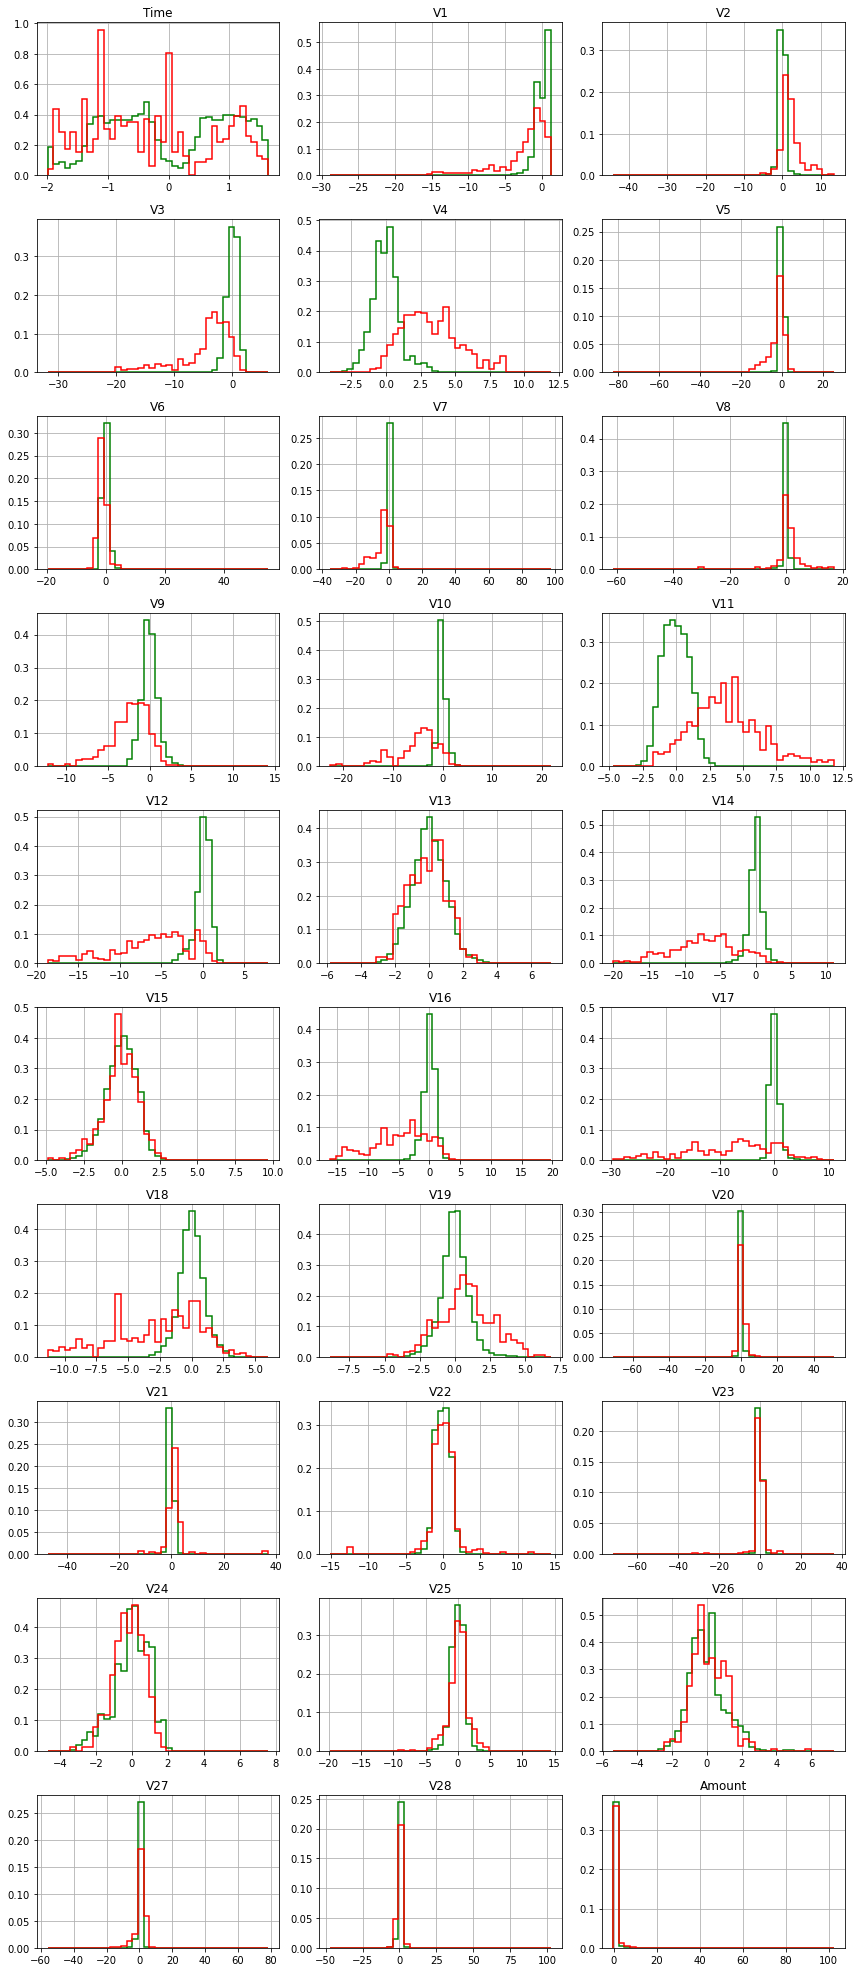

In [14]:
# Plot the distribution of input features for signal and background
fig, ax = plt.subplots(figsize=(12, 30))    # (width, height)

for n, col in enumerate(data.columns[:-1]):
    
    # Add subplot
    plt.subplot(11, 3, n+1)
    
    # Define bins
    bins = np.linspace(data[col].min(), data[col].max(), 40)
    
    # Plot entries
    data[col].loc[data['Class'] == 0].hist(bins=bins, density=True, histtype='step', color='g', linewidth=1.5, 
                                           alpha=1, ax=plt.gca())
    data[col].loc[data['Class'] == 1].hist(bins=bins, density=True, histtype='step', color='r', linewidth=1.5, 
                                           alpha=1, ax=plt.gca())
    
    # Options
    plt.title(col)
    
# Space plots nicely
plt.tight_layout()

# Save and close
# plt.savefig("/home/pablo/Documentos/challenge/plots/all_data.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

# 2) Dealing with imbalanced datasets: Undersampling, Oversampling and cross-validation

### **What are undersampling and oversampling?**

Undersampling and oversampling are two data analysis techniques used to adjust the class distribution of a data set (i.e. the ratio between the different classes represented). These techniques are designed to change the composition of a training dataset for an imbalanced classification task.

* **Undersampling:** remove examples in the majority class. In this case, we will use a random undersampling to reduce the number of background events in our sample to match the number of signal events. In this way, our models will be trained on a sample with 492 signal events and a random selection of 492 background events.

* **Oversampling:** duplicate examples in the minority class. In this case, we will use random oversampling to increase the number of signal events in our sample to match the number of background events. To do so, we will use the SMOTE technique.

### **Why is cross-validation important?**
Since we are working with a highly imbalanced dataset, we will implement a nested cross-validation technique to use all data for training and testing and avoid overfitting.

### **How do we implement these techniques?**
The undersampling and oversampling techniques must be applied with each cross-validation round. In this section, we define two functions that take the training data and truth labels, train a model using undersampling/oversampling and cross-validation, and return the predicted scores.

# 3) Fully supervised classification

In this section, we will implement three fully-supervised models for the signal vs. background classification problem. In particular, we will test the performance of:
* Random Forest
* Logistic Regression
* Neural Network 

In all cases, we will test undersampling and oversampling as our data balancing techniques. Cross validation will be used as our evaluation strategy. In this way, we will be able to use all data and our models will have better out-of-distribution generalization. For simplicity, we don't define a validation dataset. Note that this would be mandatory to analyse the model performance and tune hyperparameters in any realistic application.

Since we are dealing with a highly imbalanced dataset, we will test the performance of each models using the Precision, Recall and F1 score metrics. The AUC will be shown for reference. These metrics are useful for imbalanced classification problems because they describe the classification performance based on the minority class. We can define the working point of our model depending on our goal; maximizing precision will minimize the number false positives, whereas maximizing the recall will minimize the number of false negatives.

## 3.1) Random Forest

In [15]:
# Define test data using the full sample
X_full = data.drop(["Class"], axis=1).values
Y_full = data["Class"].values

In [16]:
print('Signal features shape: %s' % (X_full[Y_full == 1].shape,))
print('Background features shape: %s' % (X_full[Y_full == 0].shape,))

Signal features shape: (492, 30)
Background features shape: (284315, 30)


In [17]:
# Define model
model = RandomForestClassifier(n_estimators=100, max_depth=None, max_features=6)

In [18]:
# Run model and get scores
Y_pred = score_model_unbalanced(model, X_full, Y_full, name="Random Forest", n_splits=5, verbose=False)

In [19]:
# Calculate confusion matrix using truth and predicted labels
cm = confusion_matrix(Y_full, Y_pred)

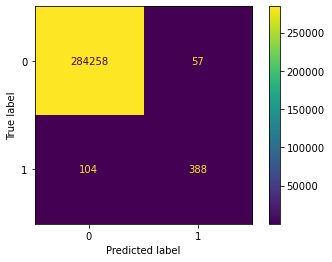

In [20]:
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot()

In [27]:
# Calculate mettrics: AUC, precision, recall and F1 score
auc_metric = roc_auc_score(Y_full, Y_pred)
precision = precision_score(Y_full, Y_pred)
recall = recall_score(Y_full, Y_pred)
f1 = f1_score(Y_full, Y_pred)

# Precision recall curve
precision_curve, recall_curve, thresholds = precision_recall_curve(Y_full, Y_pred)
auc_prc = auc(recall_curve, precision_curve)

# Calculate the random selection frontier
no_skill = len(Y_full[Y_full == 1]) / len(Y_full)

# Save metrics
RF_metrics_unbalanced = {
    'auc': auc_metric,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

In [28]:
# Print summary of metrics
print('********  Random Forest  ********')
print(f'AUC = {auc_metric:.3f}')
print(f'Precision = {precision:.3f}')
print(f'Recall = {recall:.3f}')
print(f'F1 = {f1:.3f}')

********  Random Forest  ********
AUC = 0.894
Precision = 0.872
Recall = 0.789
F1 = 0.828


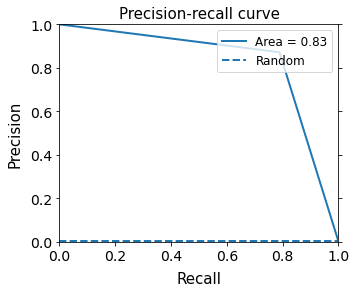

In [29]:
plot_prc(precision_curve, recall_curve, no_skill, area=auc_prc) 

## 3.2) Logistic Regression

In [30]:
# Define test data using the full sample
X_full = data.drop(["Class"], axis=1).values
Y_full = data["Class"].values

In [31]:
print('Signal features shape: %s' % (X_full[Y_full == 1].shape,))
print('Background features shape: %s' % (X_full[Y_full == 0].shape,))

Signal features shape: (492, 30)
Background features shape: (284315, 30)


### 3.2.1) Undersampling

In [32]:
# Define the model
model = LogisticRegression(max_iter=1000)

In [33]:
# Run model and get scores
Y_pred = score_model_undersampling(model, X_full, Y_full, name="Regression", n_splits=5, verbose=False)

In [34]:
# Calculate confusion matrix using truth and predicted labels
cm = confusion_matrix(Y_full, Y_pred)

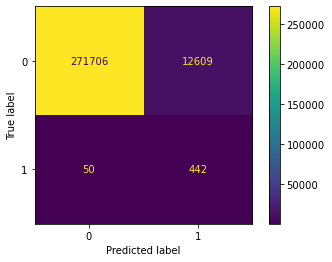

In [35]:
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot()

In [37]:
# Calculate mettrics: AUC, precision, recall and F1 score
auc_metric = roc_auc_score(Y_full, Y_pred)
precision = precision_score(Y_full, Y_pred)
recall = recall_score(Y_full, Y_pred)
f1 = f1_score(Y_full, Y_pred)

# Precision recall curve
precision_curve, recall_curve, thresholds = precision_recall_curve(Y_full, Y_pred)
auc_prc = auc(recall_curve, precision_curve)

# Calculate the random selection frontier
no_skill = len(Y_full[Y_full == 1]) / len(Y_full)

# Save metrics
LR_metrics_undersampling = {
    'auc': auc_metric,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

In [38]:
# Print summary of metrics
print('********  Logistic Regression  ********')
print(f'AUC = {auc_metric:.3f}')
print(f'Precision = {precision:.3f}')
print(f'Recall = {recall:.3f}')
print(f'F1 = {f1:.3f}')

********  Logistic Regression  ********
AUC = 0.927
Precision = 0.034
Recall = 0.898
F1 = 0.065


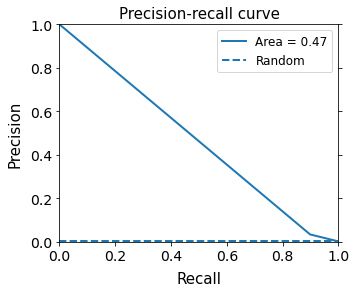

In [39]:
plot_prc(precision_curve, recall_curve, no_skill, area=auc_prc) 

### 3.2.2) Oversampling

In [40]:
# Define the model
model = LogisticRegression(max_iter=1000)

In [41]:
# Run model and get scores
Y_pred = score_model_oversampling(model, X_full, Y_full, name="Regression", n_splits=5, verbose=True)

Training: sg = 227510, bg = 227510
Testing:  sg = 157, bg = 56805

Training: sg = 227437, bg = 227437
Testing:  sg = 84, bg = 56878

Training: sg = 227473, bg = 227473
Testing:  sg = 119, bg = 56842

Training: sg = 227411, bg = 227411
Testing:  sg = 57, bg = 56904

Training: sg = 227429, bg = 227429
Testing:  sg = 75, bg = 56886



In [42]:
# Calculate confusion matrix using truth and predicted labels
cm = confusion_matrix(Y_full, Y_pred)

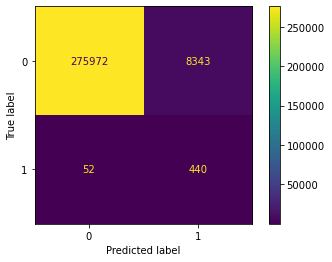

In [43]:
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot()

In [44]:
# Calculate mettrics: AUC, precision, recall and F1 score
auc_metric = roc_auc_score(Y_full, Y_pred)
precision = precision_score(Y_full, Y_pred)
recall = recall_score(Y_full, Y_pred)
f1 = f1_score(Y_full, Y_pred)

# Precision recall curve
precision_curve, recall_curve, thresholds = precision_recall_curve(Y_full, Y_pred)
auc_prc = auc(recall_curve, precision_curve)

# Calculate the random selection frontier
no_skill = len(Y_full[Y_full == 1]) / len(Y_full)

# Save metrics
LR_metrics_oversampling = {
    'auc': auc_metric,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

In [45]:
# Print summary of metrics
print('********  Logistic Regression  ********')
print(f'AUC = {auc_metric:.3f}')
print(f'Precision = {precision:.3f}')
print(f'Recall = {recall:.3f}')
print(f'F1 = {f1:.3f}')

********  Logistic Regression  ********
AUC = 0.932
Precision = 0.050
Recall = 0.894
F1 = 0.095


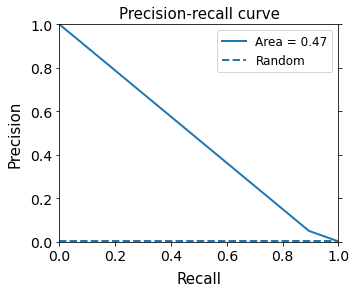

In [46]:
plot_prc(precision_curve, recall_curve, no_skill, area=auc_prc) 

## 3.3) Neural Network

In [47]:
# Define test data using the full sample
X_full = data.drop(["Class"], axis=1).values
Y_full = data["Class"].values

In [48]:
# In this case, we standardize all input features
signal = X_full[Y_full == 1]
background = X_full[Y_full == 0]

# Scale all features
signal = rob_scaler.fit_transform(signal)
background = rob_scaler.fit_transform(background)

# Redefine array with input features
X_full = np.concatenate((signal, background), axis=0)
Y_full = np.concatenate((np.ones(len(signal)), np.zeros(len(background))), axis=0)

X_full, Y_full = shuffle_2d(X_full, Y_full)

In [49]:
print('Signal features shape: %s' % (X_full[Y_full == 1].shape,))
print('Background features shape: %s' % (X_full[Y_full == 0].shape,))

Signal features shape: (492, 30)
Background features shape: (284315, 30)


### 3.3.1) Undersampling

In [59]:
# Build NN structure
model = Sequential()
model.add(Dense(64, input_dim=30, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
    
# Display the model's architecture
model.summary()

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                1984      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 32)                2080      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_22 (Dense)            (None, 16)                528       
                                                                 
 dropout_14 (Dropout)        (None, 16)                0         
                                                                 
 dense_23 (Dense)            (None, 4)                

Training: sg = 389, bg = 389
Testing:  sg = 103, bg = 56859

1781/1781 [==============================] - 1s 569us/step


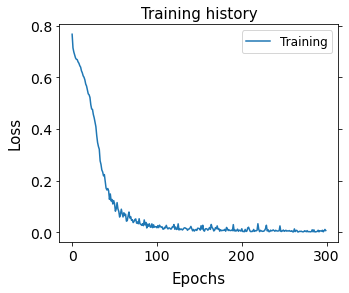

Training: sg = 391, bg = 391
Testing:  sg = 101, bg = 56861

1781/1781 [==============================] - 1s 502us/step


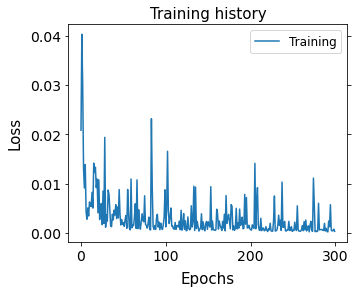

Training: sg = 398, bg = 398
Testing:  sg = 94, bg = 56867

1781/1781 [==============================] - 1s 497us/step


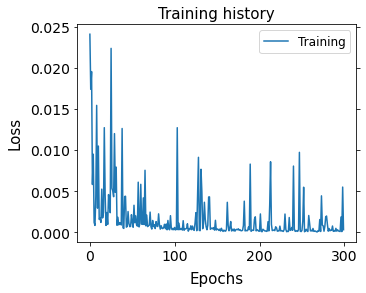

Training: sg = 389, bg = 389
Testing:  sg = 103, bg = 56858

1781/1781 [==============================] - 1s 515us/step


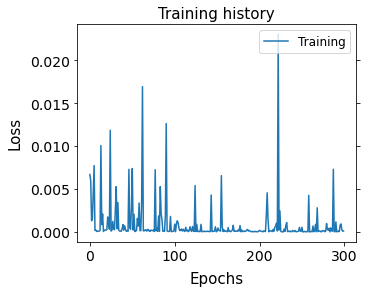

Training: sg = 401, bg = 401
Testing:  sg = 91, bg = 56870

1781/1781 [==============================] - 1s 475us/step


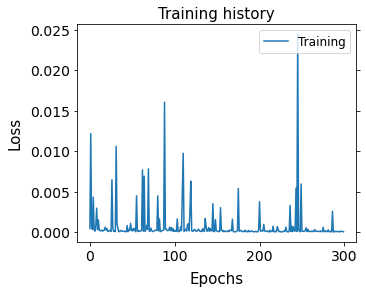

In [60]:
# Run model and get scores
Y_pred = score_model_undersampling(model, X_full, Y_full, name="NN", n_splits=5, verbose=True)

In [61]:
# Calculate confusion matrix using truth and predicted labels
cm = confusion_matrix(Y_full, Y_pred)

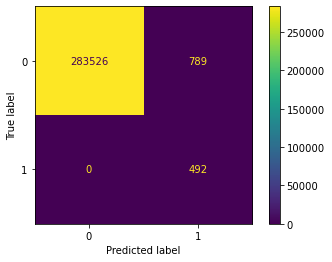

In [62]:
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot()

In [63]:
# Calculate mettrics: AUC, precision, recall and F1 score
auc_metric = roc_auc_score(Y_full, Y_pred)
precision = precision_score(Y_full, Y_pred)
recall = recall_score(Y_full, Y_pred)
f1 = f1_score(Y_full, Y_pred)

# Precision recall curve
precision_curve, recall_curve, thresholds = precision_recall_curve(Y_full, Y_pred)
auc_prc = auc(recall_curve, precision_curve)

# Calculate the random selection frontier
no_skill = len(Y_full[Y_full == 1]) / len(Y_full)

# Save metrics
NN_metrics_undersampling = {
    'auc': auc_metric,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

In [64]:
# Print summary of metrics
print('********  Neural Network  ********')
print(f'AUC = {auc_metric:.3f}')
print(f'Precision = {precision:.3f}')
print(f'Recall = {recall:.3f}')
print(f'F1 = {f1:.3f}')

********  Neural Network  ********
AUC = 0.999
Precision = 0.384
Recall = 1.000
F1 = 0.555


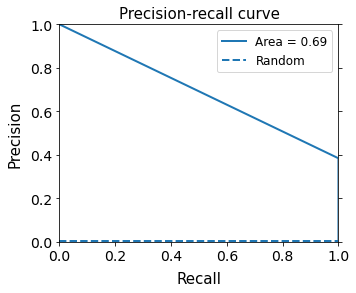

In [65]:
plot_prc(precision_curve, recall_curve, no_skill, area=auc_prc) 

### 3.3.2) Oversampling

In [67]:
# Build NN structure
model = Sequential()
model.add(Dense(64, input_dim=30, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
    
# Display the model's architecture
model.summary()

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 64)                1984      
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 32)                2080      
                                                                 
 dropout_19 (Dropout)        (None, 32)                0         
                                                                 
 dense_32 (Dense)            (None, 16)                528       
                                                                 
 dropout_20 (Dropout)        (None, 16)                0         
                                                                 
 dense_33 (Dense)            (None, 4)                

Training: sg = 227456, bg = 227456
Testing:  sg = 103, bg = 56859

1781/1781 [==============================] - 1s 538us/step


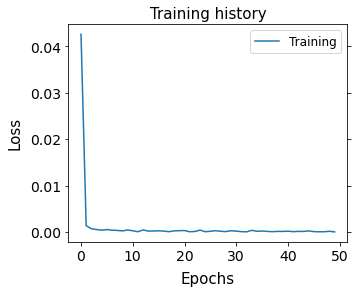

Training: sg = 227454, bg = 227454
Testing:  sg = 101, bg = 56861

1781/1781 [==============================] - 1s 534us/step


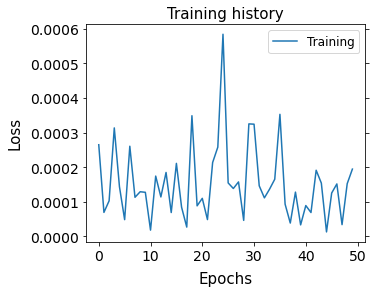

Training: sg = 227448, bg = 227448
Testing:  sg = 94, bg = 56867

1781/1781 [==============================] - 1s 508us/step


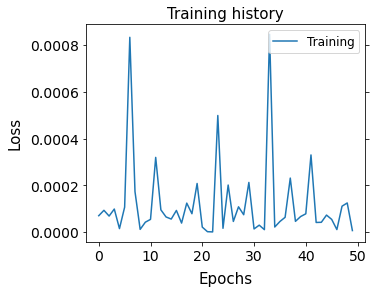

Training: sg = 227457, bg = 227457
Testing:  sg = 103, bg = 56858

1781/1781 [==============================] - 1s 525us/step


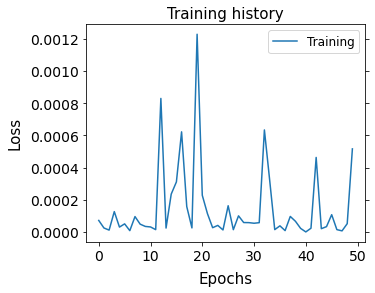

Training: sg = 227445, bg = 227445
Testing:  sg = 91, bg = 56870

1781/1781 [==============================] - 1s 529us/step


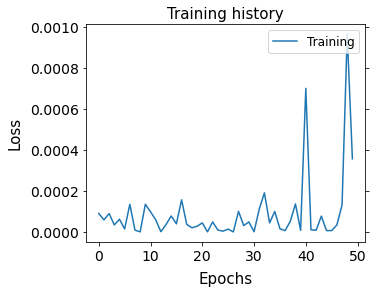

In [68]:
# Run model and get scores
Y_pred = score_model_oversampling(model, X_full, Y_full, name="NN", n_splits=5, verbose=True)

In [69]:
# Calculate confusion matrix using truth and predicted labels
cm = confusion_matrix(Y_full, Y_pred)

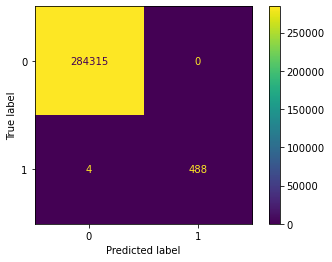

In [70]:
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot()

In [71]:
# Calculate mettrics: AUC, precision, recall and F1 score
auc_metric = roc_auc_score(Y_full, Y_pred)
precision = precision_score(Y_full, Y_pred)
recall = recall_score(Y_full, Y_pred)
f1 = f1_score(Y_full, Y_pred)

# Precision recall curve
precision_curve, recall_curve, thresholds = precision_recall_curve(Y_full, Y_pred)
auc_prc = auc(recall_curve, precision_curve)

# Calculate the random selection frontier
no_skill = len(Y_full[Y_full == 1]) / len(Y_full)

# Save metrics
NN_metrics_oversampling = {
    'auc': auc_metric,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

In [72]:
# Print summary of metrics
print('********  Neural Network  ********')
print(f'AUC = {auc_metric:.3f}')
print(f'Precision = {precision:.3f}')
print(f'Recall = {recall:.3f}')
print(f'F1 = {f1:.3f}')

********  Neural Network  ********
AUC = 0.996
Precision = 1.000
Recall = 0.992
F1 = 0.996


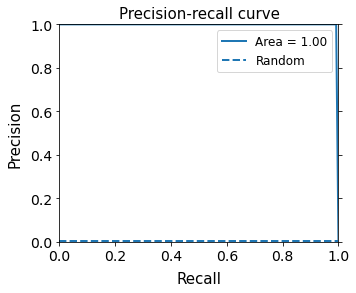

In [73]:
plot_prc(precision_curve, recall_curve, no_skill, area=auc_prc) 

# 4) Unsupervised: Variational Autoencoder (VAE)

Anomaly detection is unsupervised in nature. In this section, we explore if we can use a Variational Autoencoder on the dataset (ignoring the class labels) to isolate a fraction of anomalous signal-like events. We will train the VAE to learn the background distribution of events using the Minimum Squared Error (MSE). We will then test the model on all the dataset and isolate a sample of events with large reconstruction error, which will be labeled as anomalous signal-like events.

In [75]:
# Define test data using the full sample
X_full = data.drop(["Class"], axis=1).values
Y_full = data["Class"].values

# Scale all features
X_full = rob_scaler.fit_transform(X_full)

# Shuffle arrays
X_full, Y_full = shuffle_2d(X_full, Y_full)

# Get signal and background arrays
signal = X_full[Y_full == 1]
background = X_full[Y_full == 0]

In [76]:
print('Signal features shape: %s' % (X_full[Y_full == 1].shape,))
print('Background features shape: %s' % (X_full[Y_full == 0].shape,))

Signal features shape: (492, 30)
Background features shape: (284315, 30)


### 4.1) Define class to sample latent space

In [77]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### 4.2) Build VAE

In [78]:
original_dim = X_full.shape[1]
latent_dim = 2

# Create encoder
encoder_inputs = Input(shape=(original_dim,), name="original_input")
x = Dense(64, activation='relu')(encoder_inputs)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
    
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])

encoder = Model(inputs=encoder_inputs, outputs=z, name='encoder')
encoder.summary()

# Create decoder
latent_inputs = Input(shape=(latent_dim,), name="z_sampling")
x = Dense(16, activation="relu")(latent_inputs)
x = Dense(32, activation="relu")(x)
x = Dense(64, activation="relu")(x)
decoder_outputs = Dense(original_dim, activation="linear")(x)
    
decoder = Model(inputs=latent_inputs, outputs=decoder_outputs, name="decoder")
decoder.summary()

# Define VAE
decoder_outputs = decoder(z)
vae = Model(inputs=encoder_inputs, outputs=decoder_outputs, name="vae")

# Add KL divergence regularization loss
kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
vae.add_loss(kl_loss)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 original_input (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 dense_35 (Dense)               (None, 64)           1984        ['original_input[0][0]']         
                                                                                                  
 dense_36 (Dense)               (None, 32)           2080        ['dense_35[0][0]']               
                                                                                                  
 dense_37 (Dense)               (None, 16)           528         ['dense_36[0][0]']               
                                                                                            

### 4.3) Train VAE

In [79]:
# Train
optimizer = tf.keras.optimizers.Adam()
vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
vae.fit(X_full, X_full, epochs=50, batch_size=128)

Epoch 1/50
2226/2226 [==============================] - 3s 1ms/step - loss: 1.8209
Epoch 2/50
2226/2226 [==============================] - 3s 1ms/step - loss: 1.7635
Epoch 3/50
2226/2226 [==============================] - 3s 1ms/step - loss: 1.7483
Epoch 4/50
2226/2226 [==============================] - 3s 1ms/step - loss: 1.7198
Epoch 5/50
2226/2226 [==============================] - 3s 1ms/step - loss: 1.6615
Epoch 6/50
2226/2226 [==============================] - 3s 1ms/step - loss: 1.6341
Epoch 7/50
2226/2226 [==============================] - 3s 1ms/step - loss: 1.6184
Epoch 8/50
2226/2226 [==============================] - 3s 1ms/step - loss: 1.6265
Epoch 9/50
2226/2226 [==============================] - 3s 1ms/step - loss: 1.6123
Epoch 10/50
2226/2226 [==============================] - 3s 1ms/step - loss: 1.6700
Epoch 11/50
2226/2226 [==============================] - 3s 1ms/step - loss: 1.6176
Epoch 12/50
2226/2226 [==============================] - 3s 1ms/step - loss: 1.6022
E

### 4.4) Make predictions

In [80]:
# Make predictions
X_pred = vae.predict(X_full)

# Calculate MSE
mse = np.mean(np.square(X_full - X_pred), axis=-1)

8901/8901 [==============================] - 5s 562us/step


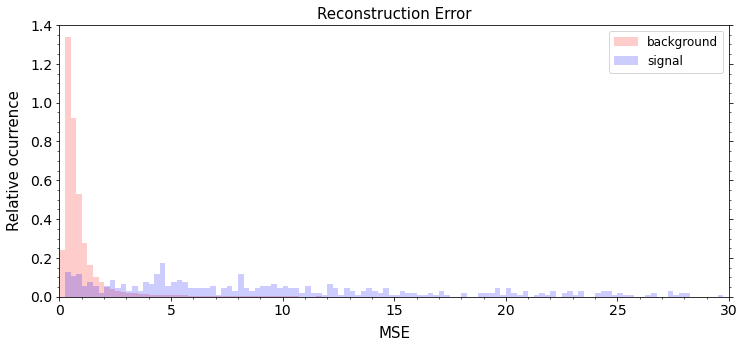

In [86]:
fig = plt.figure(figsize=(12,5))

# Get mse
sg_mse = mse[Y_full == 1]
bg_mse = mse[Y_full == 0]

# Plot mse
plt.hist(bg_mse, range = (0, 30), density=True,
         bins=120, facecolor='r', alpha=0.2,label='background')
plt.hist(sg_mse, range = (0, 30), density=True,
         bins=120, facecolor='b', alpha=0.2,label='signal')

# Options
plt.title(r'Reconstruction Error', fontsize=15)
plt.xlabel(r'MSE', fontsize=15, labelpad=8)
plt.ylabel(r'Relative ocurrence', fontsize=15, labelpad=8)
plt.legend(loc='upper right', fontsize=12)
plt.xlim([0.0, 30.0])
plt.ylim([0.0, 1.4])

plt.tick_params(which='both', direction='out', bottom=True, left=True, right=True, labelsize=14)
plt.minorticks_on()

plt.show()

In [107]:
# Define threshold
threshold = 5

# Initilialize class predictions array
Y_pred = np.zeros(len(mse))

# Set class of anomalous events to 1
Y_pred[mse >= threshold] = 1

In [108]:
# Calculate confusion matrix using truth and predicted labels
cm = confusion_matrix(Y_full, Y_pred)

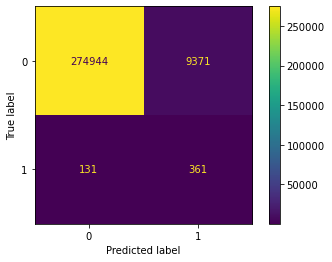

In [109]:
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot()

In [110]:
# Calculate mettrics: AUC, precision, recall and F1 score
auc_metric = roc_auc_score(Y_full, Y_pred)
precision = precision_score(Y_full, Y_pred)
recall = recall_score(Y_full, Y_pred)
f1 = f1_score(Y_full, Y_pred)

# Precision recall curve
precision_curve, recall_curve, thresholds = precision_recall_curve(Y_full, Y_pred)
auc_prc = auc(recall_curve, precision_curve)

# Calculate the random selection frontier
no_skill = len(Y_full[Y_full == 1]) / len(Y_full)

# Save metrics
VAE_metrics = {
    'auc': auc_metric,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

In [111]:
# Print summary of metrics
print('********  Variational Autoencoder  ********')
print(f'AUC = {auc_metric:.3f}')
print(f'Precision = {precision:.3f}')
print(f'Recall = {recall:.3f}')
print(f'F1 = {f1:.3f}')

********  Variational Autoencoder  ********
AUC = 0.850
Precision = 0.037
Recall = 0.734
F1 = 0.071


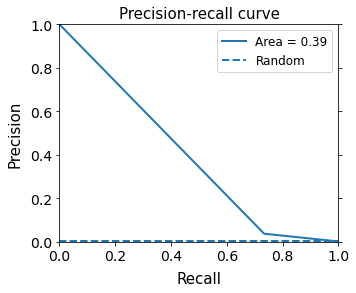

In [112]:
plot_prc(precision_curve, recall_curve, no_skill, area=auc_prc) 

### 4.5) Visualize latent space

In [113]:
# Get compressed features in latent space
z_mean = encoder.predict(X_full)

8901/8901 [==============================] - 4s 484us/step


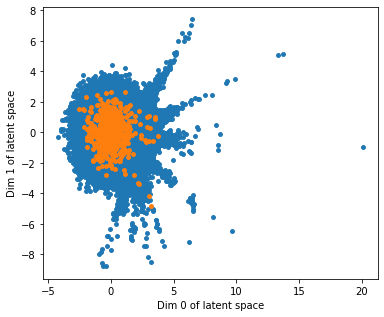

In [114]:
def plot_label_clusters(z_mean, labels):    
    # display a 2D plot of the digit classes in the latent space
    plt.figure(figsize=(6, 5))
    events_bg = z_mean[labels == 0]
    events_sg = z_mean[labels == 1]
    plt.scatter(events_bg[:,0], events_bg[:,1], color='C0', s=15)
    plt.scatter(events_sg[:,0], events_sg[:,1], color='C1', s=15)
    plt.xlabel("Dim 0 of latent space")
    plt.ylabel("Dim 1 of latent space")
    plt.show()

plot_label_clusters(z_mean, Y_full)

### 4.6) Visualize features of the anomalous signal-like events

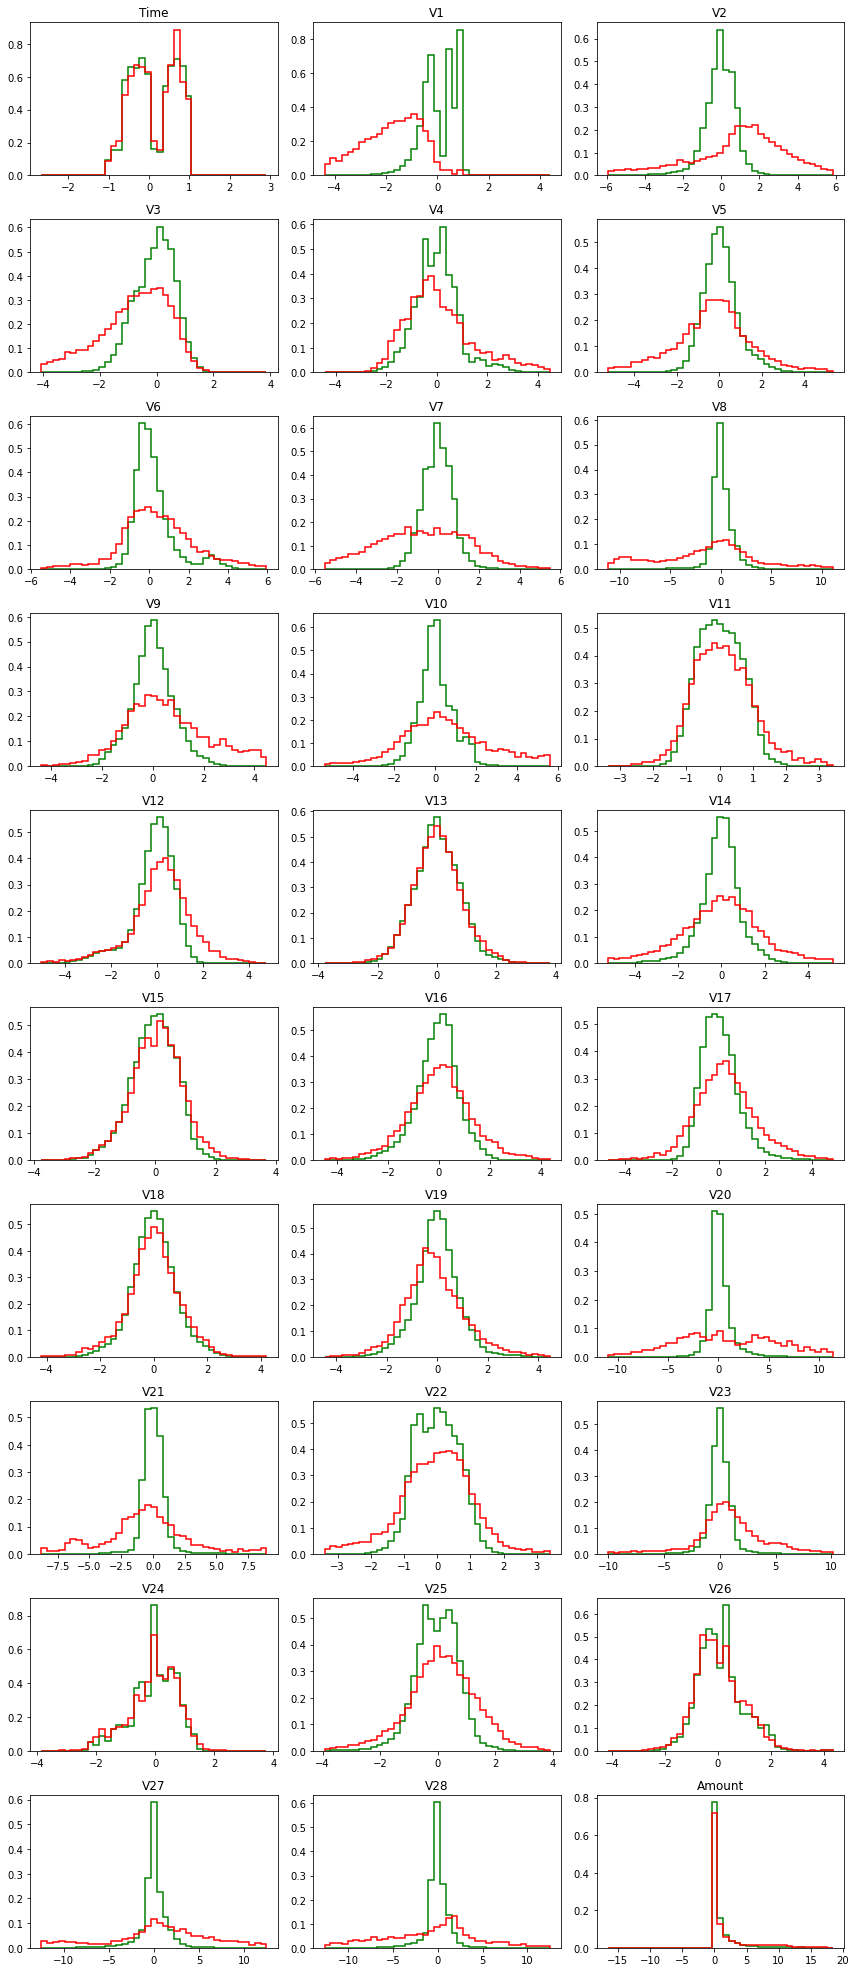

In [115]:
# Plot the distribution of input features for signal and background
fig, ax = plt.subplots(figsize=(12, 30))    # (width, height)

for i in range(X_full.shape[1]):
    
    # Add subplot
    plt.subplot(11, 3, i+1)
    
    # Define bins
    bins = np.linspace(X_full[:,i].mean() - 5*X_full[:,i].std(), 
                       X_full[:,i].mean() + 5*X_full[:,i].std(), 
                       40)
    
    # Plot entries
    plt.hist(X_full[mse < threshold][:,i], bins=bins, density=True, histtype='step', color='g', linewidth=1.5, 
                                           alpha=1)
    plt.hist(X_full[mse >= threshold][:,i], bins=bins, density=True, histtype='step', color='r', linewidth=1.5, 
                                           alpha=1)
    
    # Options
    plt.title(data.columns[i])
    
# Space plots nicely
plt.tight_layout()

# Save and close
# plt.savefig("/home/pablo/Documentos/challenge/plots/all_data.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

# 5) Compare metrics

In [162]:
# Group all metrics together
models = [RF_metrics_undersampling,
          LR_metrics_undersampling,
          LR_metrics_oversampling,
          NN_metrics_undersampling,
          NN_metrics_oversampling,
          VAE_metrics
         ]

# Group all models for each metric
auc_all = [model['auc'] for model in models]
precision_all = [model['precision'] for model in models]
recall_all = [model['recall'] for model in models]
f1_all = [model['f1'] for model in models]

# Define labels for the plot
labels = [r'RF' '\n' 'Unbal.',
          r'LR' '\n' 'Under.',
          r'LR' '\n' 'Over.',
          r'NN' '\n' 'Under.',
          r'NN' '\n' 'Over.',
          r'VAE' '\n' 'Unbal.',
         ]

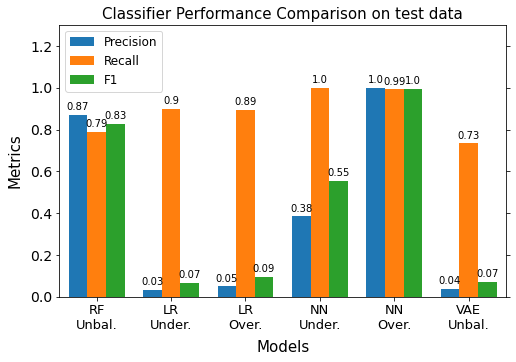

In [164]:
# Define number of models and metrics to display
n_models = len(labels)
n_metrics = 3

# Define width of the bars
bar_width = 1

# Define centered position of each group of bars on the x axis
x_group = np.arange(n_metrics, n_models*(n_metrics+1) + 1, n_metrics+1)

# Define position of each bar on the x axis
x_b1 = [loc - 1 for loc in x_group]
x_b2 = [loc for loc in x_group]
x_b3 = [loc + 1 for loc in x_group]

# Define figure
plt.figure(figsize=(8, 5))

# Plot bars
bar1 = plt.bar(x_b1, precision_all, bar_width, color='C0', label='Precision')
bar2 = plt.bar(x_b2, recall_all, bar_width, color='C1', label='Recall')
bar3 = plt.bar(x_b3, f1_all, bar_width, color='C2', label='F1')

# Add labels with the metrics to the bars
plt.gca().bar_label(bar1, labels=np.round(precision_all, decimals=2), padding=3)
plt.gca().bar_label(bar2, labels=np.round(recall_all, decimals=2), padding=3)
plt.gca().bar_label(bar3, labels=np.round(f1_all, decimals=2), padding=3)

# Options
plt.title(r'Classifier Performance Comparison on test data', fontsize=15)
plt.xlabel(r'Models', fontsize=15, labelpad=8)
plt.ylabel(r'Metrics', fontsize=15, labelpad=8)
plt.legend(loc='best', fontsize=12)
plt.xlim([1.0, 25.0])
plt.ylim([0.0, 1.3])
plt.tick_params(which='both', direction='out', bottom=True, left=True, right=True, labelsize=14)

# Set x and y main axis labels
plt.gca().set_xticks(x_group)
plt.gca().set_xticklabels(labels, fontsize=13)
#plt.gca().set_yticks([1, 10**1, 10**2, 10**3])
#plt.gca().set_yticklabels([r'$1$', r'$10^1$', r'$10^2$', r'$10^3$'])

fig.tight_layout()

plt.show()

# 6) Analyze results

We analyzed four different baseline models and considered the following scenarios:
* Random Forest on the unbalanced dataset
* Logistic Regression with undersampling
* Logistic Regression with oversampling
* Neural Network with undersampling
* Neural Network with oversampling

Note that the results presented for these baseline models could get better by optimizing the models.

An out-of-the-box implementation for the Random Forest has a very good performance. This model is the first technique to consider in most problems with tabular data. Note that it clearly outperforms the simple Logistic Regression model. In addition, it could outperform the Neural Network trained with random undersampling. Note that the decision threshold of the Neural Network could be tuned to change the balanced between precision and recall.

The Neural Network trained with oversampling clearly outperforms the rest of models, achieving near-optimal performance on the test dataset. However, note that this model requires longer training times.

Finally, we tested the performance of a Variational Autoencoder on an unsupervised version of the problem, in which the trained model has no access to the class labels. In this version of the problem, the goal is to catch the largest amount of signal events as possible, even at the expense of a high false positive rate. With this in mind, we see that the VAE model gives a good performance.